In [1]:
# this notebook is originally from Tim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hydra import initialize, compose
import torch

from numpy.lib import scimath as SM

from case_studies.dc2_cataloging.utils.notebook_plotting_params import NoteBookPlottingParams
from bliss.surveys.dc2 import DC2DataModule
from hydra.utils import instantiate
from bliss.catalog import FullCatalog, TileCatalog
from pathlib import Path

# in Tim and Shreyas data, objects don't have flux less than 200
base_flux_bin_cutoffs = [400, 600, 800, 1000]
mag_bin_labels = ["< 23.9", "[23.9, 24.1]", "[24.1, 24.5]",
                  "[24.5, 24.9]", "[24.9, 25.6]"]
tile_slen = 4
image_lim = 4000
sub_image_len = 100
bands = ("u", "g", "r", "i", "z", "y")

output_dir = Path("./plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [2]:
def get_mag_bin_labels(flux: np.ndarray, flux_bin_cutoffs, mag_bin_labels):
    flux_bin_indexes = np.digitize(flux, flux_bin_cutoffs)
    mag_bin_indexes = len(mag_bin_labels) - flux_bin_indexes - 1
    return np.take_along_axis(np.array(mag_bin_labels), 
                              indices=mag_bin_indexes, 
                              axis=0)

In [3]:
# load in catalog, take subset for computational efficiency, drop nans
# since we still can't run the generate_catalog.ipynb, we use the catalog from Tim and Shreyas
cat = pd.read_pickle("/data/scratch/dc2local/dc2_lensing_catalog.pkl")
# cat = cat.sample(n = int(1e5))

In [4]:
cat.columns

Index(['mag_z', 'mag_y', 'id', 'mag_i', 'flux_r', 'dec', 'ra', 'mag_u',
       'cosmodc2_id', 'truth_type', 'mag_g', 'redshift', 'flux_y', 'flux_z',
       'flux_i', 'flux_g', 'flux_u', 'match_objectId', 'mag_r', 'Iyy_pixel',
       'IxyPSF_pixel_u', 'IxxPSF_pixel_u', 'IxxPSF_pixel_z', 'IxyPSF_pixel_g',
       'IyyPSF_pixel_u', 'IxxPSF_pixel_y', 'IxyPSF_pixel_i', 'IxxPSF_pixel_i',
       'IyyPSF_pixel_i', 'IyyPSF_pixel_r', 'psf_fwhm_u', 'IxyPSF_pixel_r',
       'psf_fwhm_r', 'psf_fwhm_z', 'IxyPSF_pixel_z', 'Ixy_pixel',
       'IyyPSF_pixel_y', 'IxyPSF_pixel_y', 'psf_fwhm_i', 'IxxPSF_pixel_r',
       'Ixx_pixel', 'IyyPSF_pixel_g', 'psf_fwhm_g', 'psf_fwhm_y',
       'IxxPSF_pixel_g', 'IyyPSF_pixel_z', 'convergence', 'galaxy_id',
       'ellipticity_2_true', 'ellipticity_1_true', 'shear_2', 'shear_1'],
      dtype='object')

In [5]:
cat.dropna(subset=["id", "cosmodc2_id", "match_objectId", 
                    "ra", "dec",
                    "flux_r",
                    "Ixx_pixel", "Ixy_pixel", "Iyy_pixel",
                    "ellipticity_1_true", "ellipticity_2_true"], 
           inplace=True)
cat["mag_bin"] = get_mag_bin_labels(cat["flux_r"], base_flux_bin_cutoffs, mag_bin_labels)
cat["mag_bin"] = pd.Categorical(cat["mag_bin"], categories=mag_bin_labels, ordered=True)

In [6]:
# this is the function from https://github.com/LSSTDESC/DC2-analysis/blob/master/validation/validate_dc2_run2.2i_object_table.ipynb
# thank Tim for finding this useful repos
def ellipticity(I_xx, I_xy, I_yy):
    """Calculate ellipticity from second moments.

    Parameters
    ----------
    I_xx : float or numpy.array
    I_xy : float or numpy.array
    I_yy : float or numpy.array

    Returns
    -------
    e, e1, e2 : (float, float, float) or (numpy.array, numpy.array, numpy.array)
        Complex ellipticity, real component, imaginary component
        
    Copied from https://github.com/lsst/validate_drp/python/lsst/validate/drp/util.py
    """
    e = (I_xx - I_yy + 2j * I_xy) / (I_xx + I_yy + 2 * SM.sqrt(I_xx * I_yy - I_xy * 2))
    e1 = np.real(e)
    e2 = np.imag(e)
    return e, e1, e2

In [7]:
est_ellip, est_ellip1, est_ellip2 = ellipticity(cat["Ixx_pixel"].values, 
                                                cat["Ixy_pixel"].values, 
                                                cat["Iyy_pixel"].values)
est_theta = np.arctan2(est_ellip2, est_ellip1)
cat["ellipticity_est"] = est_ellip
cat["ellipticity_1_est"] = est_ellip1
cat["ellipticity_2_est"] = est_ellip2
cat["ellipticity_theta_est"] = est_theta
cat["ellipticity_theta_true"] = np.arctan2(cat["ellipticity_2_true"], 
                                           cat["ellipticity_1_true"])

In [8]:
print(np.corrcoef(cat["ellipticity_1_true"], cat["ellipticity_1_est"]))
print(np.corrcoef(cat["ellipticity_2_true"], cat["ellipticity_2_est"]))

[[ 1.00000000e+00 -7.22960443e-04]
 [-7.22960443e-04  1.00000000e+00]]
[[1.00000000e+00 9.10414226e-05]
 [9.10414226e-05 1.00000000e+00]]


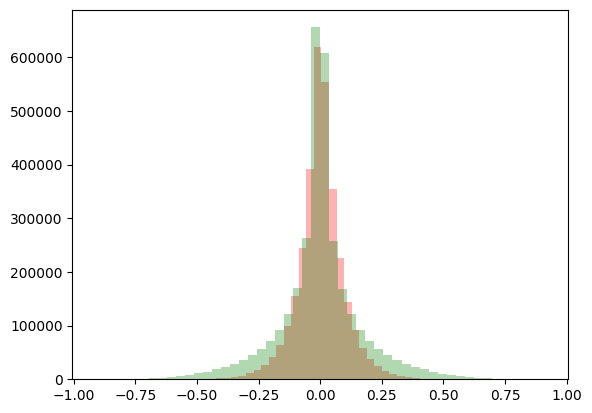

In [9]:
plt.hist(cat["ellipticity_1_est"], alpha=0.3, color="red", bins=50)
plt.hist(cat["ellipticity_1_true"], alpha=0.3, color="green", bins=50)
plt.show()

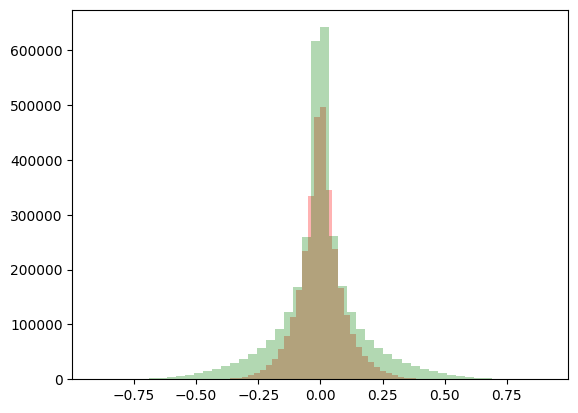

In [10]:
plt.hist(cat["ellipticity_2_est"], alpha=0.3, color="red", bins=50)
plt.hist(cat["ellipticity_2_true"], alpha=0.3, color="green", bins=50)
plt.show()

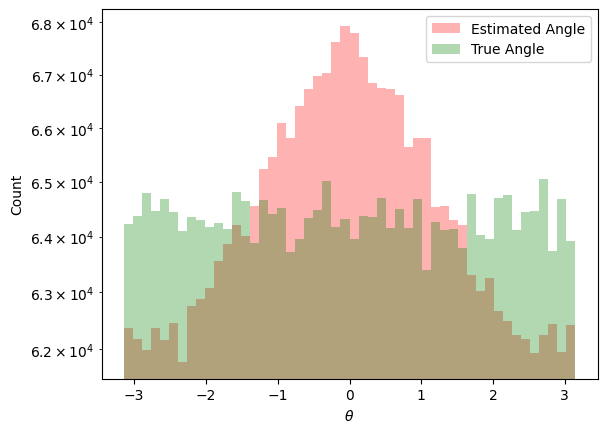

In [11]:
plt.hist(cat["ellipticity_theta_est"], alpha=0.3, log=True, color="red", bins=50, label="Estimated Angle")
plt.hist(cat["ellipticity_theta_true"], alpha=0.3, log=True, color="green", bins=50, label="True Angle")
plt.xlabel(r"$\theta$")
plt.ylabel("Count")
plt.legend()
plt.show()

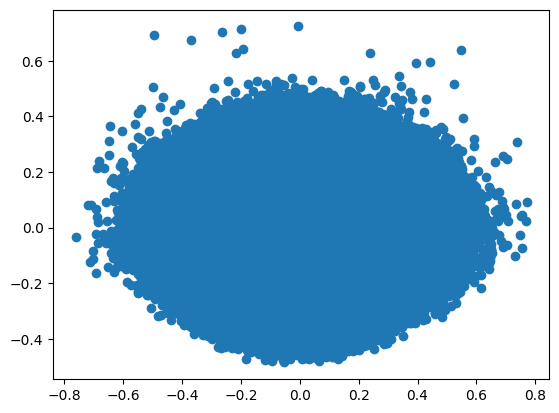

In [12]:
plt.scatter(cat["ellipticity_1_est"], cat["ellipticity_2_est"])
plt.show()

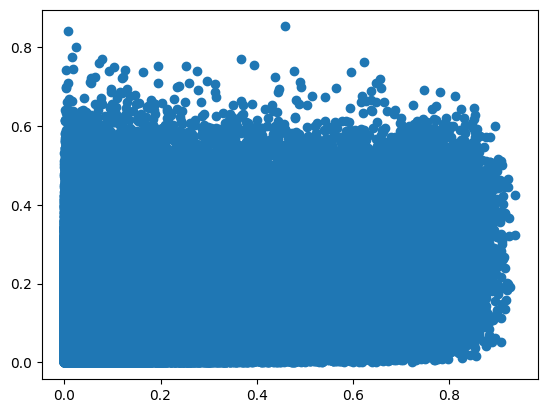

In [13]:
plt.scatter(np.sqrt(cat["ellipticity_1_true"] ** 2 + cat["ellipticity_2_true"] ** 2),
            np.abs(cat["ellipticity_est"]))
plt.show()

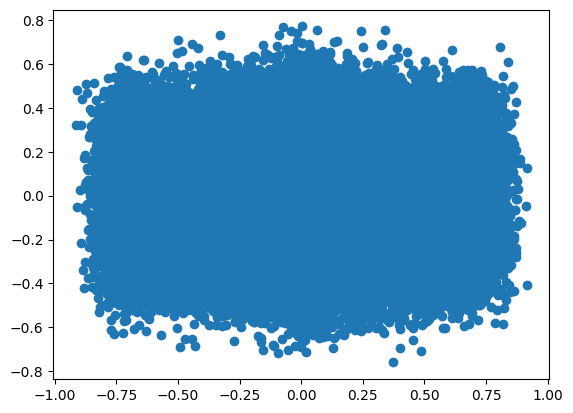

In [14]:
plt.scatter(cat["ellipticity_1_true"], cat["ellipticity_1_est"])
plt.show()

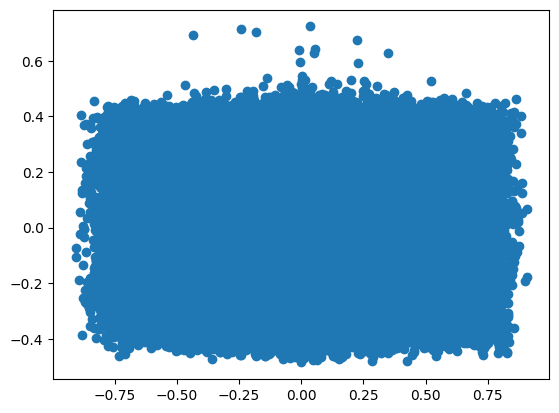

In [15]:
plt.scatter(cat["ellipticity_2_true"], cat["ellipticity_2_est"])
plt.show()

In [16]:
def plot_ellipticity(e_num):
    nrows = 3
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                           figsize=(NoteBookPlottingParams.figsize[0] * ncols,
                                    NoteBookPlottingParams.figsize[1] * nrows),
                            sharex="col", sharey="row")
    for i, mag_bin in enumerate(mag_bin_labels):
        mag_bin_data = cat.loc[cat["mag_bin"] == mag_bin]
        ax = axes[i % nrows, i // nrows]
        ax.scatter(mag_bin_data[f"ellipticity_{e_num}_true"],
                    mag_bin_data[f"ellipticity_{e_num}_est"],
                    s=20.0,
                    alpha=0.6,
                    edgecolors="none",
                    color=NoteBookPlottingParams.color_dict["lsst"])
        ax.axline([0, 0], [1, 1], color="grey", alpha=0.5)
        ax.set_title("Magnitude " + mag_bin, fontsize=NoteBookPlottingParams.fontsize)
        ax.grid(visible=True, axis="y")
        ax.grid(visible=True, axis="x")

        ax.set_xlabel(f"True $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)
        ax.tick_params(labelsize=NoteBookPlottingParams.fontsize)
        ax.set_ylabel(f"Estimated $e_{e_num}$", fontsize=NoteBookPlottingParams.fontsize)

        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

    fig.tight_layout()

    return fig

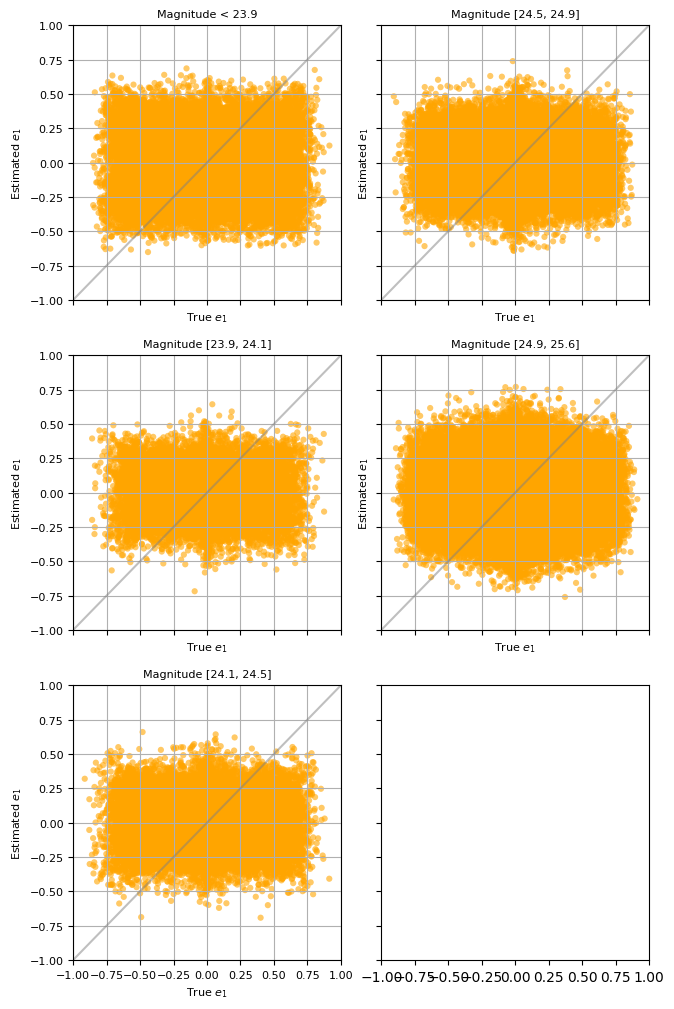

In [17]:
fig = plot_ellipticity(e_num=1)
fig.show()

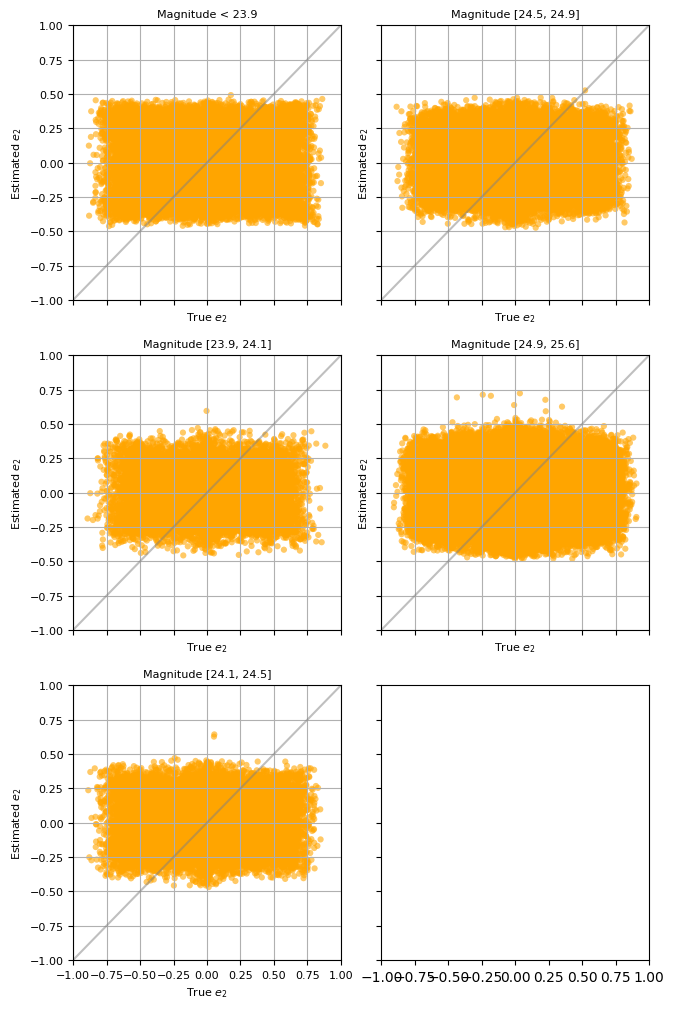

In [18]:
fig = plot_ellipticity(e_num=2)
fig.show()

In [19]:
dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)
image = test_sample["image"]

In [20]:
true_tile_dict = DC2DataModule.unsqueeze_tile_dict(test_sample["tile_catalog"])
true_full_cat = TileCatalog(true_tile_dict).to_full_catalog(tile_slen=tile_slen)

In [21]:
e_output_dir = output_dir / "lsst_ellipticity_est"
e_output_dir.mkdir(exist_ok=True)

In [22]:
def plot_ellipticity_on_image(true_full_cat: FullCatalog, image: torch.Tensor):
    for i in range(0, image_lim, sub_image_len):
        for j in range(0, image_lim, sub_image_len):
            plocs_box_origin = torch.tensor([i, j])
            cur_target_full_cat = true_full_cat.filter_by_ploc_box(plocs_box_origin, 
                                                                   sub_image_len)
            image_sub = image[:, i:(i + sub_image_len), j:(j + sub_image_len)]
            image_sub_0_1 = ((image_sub + 0.5).norm(dim=0, p=1) / len(bands)).clamp(min=0, max=1)
            image_sub = (image_sub_0_1 * 255).clamp(min=0, max=255)

            true_df = pd.DataFrame({
                "id": cur_target_full_cat["objid"].flatten(),
                "plocs_x": cur_target_full_cat["plocs"][0, :, 1],
                "plocs_y": cur_target_full_cat["plocs"][0, :, 0],
            })
            est_ellip_df = true_df.merge(cat,
                                           left_on="id",
                                           right_on="id",
                                           how="left")
            est_ellip_df.dropna(subset=["id", "plocs_x", "plocs_y",
                                        "ellipticity_1_est", "ellipticity_2_est",
                                        "ellipticity_1_true", "ellipticity_2_true"],
                                inplace=True)
            est_ellip_df = est_ellip_df[["id", "plocs_x", "plocs_y",
                                        "ellipticity_1_est", "ellipticity_2_est",
                                        "ellipticity_1_true", "ellipticity_2_true"]]

            fig, ax = plt.subplots(figsize=(NoteBookPlottingParams.figsize[0] * 2,
                                            NoteBookPlottingParams.figsize[1] * 2))
            ax.imshow(image_sub, cmap="gray", vmin=0, vmax=255)
            ax.scatter(est_ellip_df["plocs_x"], 
                       est_ellip_df["plocs_y"], 
                       marker="x",
                       color="blue")
            
            for _i, row in est_ellip_df.iterrows():
                e1_est = row["ellipticity_1_est"]
                e2_est = row["ellipticity_2_est"]
                e1_true = row["ellipticity_1_true"]
                e2_true = row["ellipticity_2_true"]
                ax.text(row["plocs_x"] + 0.2, row["plocs_y"] + 0.2, 
                        f"e1_est={e1_est: .3f}; e2_est={e2_est: .3f};\ne1_true={e1_true: .3f}; e2_true={e2_true: .3f}", 
                        fontsize=NoteBookPlottingParams.fontsize,
                        color="red")

            ax.tick_params(labelsize=NoteBookPlottingParams.fontsize * 2)

            fig.savefig(e_output_dir / f"image_{i}_{j}.pdf",
                        bbox_inches="tight",
                        dpi=NoteBookPlottingParams.dpi)
            fig.show()
            plt.close()

In [ ]:
plot_ellipticity_on_image(true_full_cat, image)